In [1]:
# import library
import numpy as np 
import pandas as pd
import re
import os

import matplotlib.pyplot as plt
%matplotlib inline

import keras
import keras.utils
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten

from functools import partial
from keras import metrics

In [2]:
MAX_SEQUENCES_LENGTH = 50 # Maximum kata pada kalimat
MAX_NB_WORDS = 6000 # Vocabulary size
EMBEDDING_DIM = 50 # Dimensions of Glove word vector kadang bisa juga 100

In [3]:
# open dataset,save on dataframe
df = pd.read_csv("just_stemming.csv",encoding="ISO-8859-1")

# membuka data slang (data yang akan dibenarkan)
with open('slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
    for line in file if line.strip())
    
df.head()

,text,label
0,konflik rebut tanah,0
1,palestina taat kaffah islam ganti demokrasi si...,0
2,palestina rohingya konflik politik sih oknum l...,1
3,teroris islam gejala imbas konflik israel pale...,1
4,gregetan turun moderat peduli zionisme gera du...,2


In [4]:
# delete data label netral
df = df[df.label != 0]

In [5]:
df

,text,label
2,palestina rohingya konflik politik sih oknum l...,1
3,teroris islam gejala imbas konflik israel pale...,1
4,gregetan turun moderat peduli zionisme gera du...,2
5,tolong negara negara arab tegak bebas hak asas...,1
7,konflik israel palestina kompleks,1
...,...,...
1397,konflik israel palestina urus ikut salah terta...,1
1398,konflik israel palestina konflik agama palesti...,1
1399,target gencat senjata permanen,1
1400,support palestine cuma kadang miris jalan bant...,1


In [6]:
df.loc[df['label'] == 2, 'label'] = 0

1    686
0    346
Name: label, dtype: int64


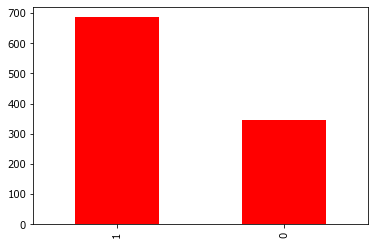

In [7]:
# menghitung Label sentimen (menampilkan tabel pembagian label sentimen)
labels = df.label
labels_count = labels.value_counts()
labels_count.plot(kind="bar", x='Label', y='Jumlah', color='red')
print(labels.value_counts())

In [8]:
# Prepare to X as Feature
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
sequences = tokenizer.texts_to_sequences(df.text)
# Banyak kata yang telah di tokenizer
word_index = tokenizer.word_index

In [9]:
print('Found %d unique words.' % len(word_index))

Found 2289 unique words.


In [10]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')

In [11]:
# Prepare to y as label
y = df["label"]

In [12]:
classes = ['0', '1']

In [13]:
# Membuka dataset yg telah di panggil di file local
# with open('pengujian/final/split_dataset/datset60.pickle', 'rb') as f:
#     X_train80, X_test80, y_train80, y_test80 = pickle.load(f)

In [14]:
# open Glove
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join('dataset/glove/vectors.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 331286 word vectors.


In [15]:
# Use GloVe as Word Embedding
hits = 0
misses = 0
index = []
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        index.append(word)

In [16]:
test = embeddings_index.get("netizen")
test

array([-4.327230e-01, -3.119420e-01,  1.094491e+00, -2.145950e-01,
        7.534390e-01,  1.659070e+00,  4.936180e-01,  1.409000e-03,
        4.884600e-01,  2.542550e-01, -4.979390e-01,  5.617340e-01,
        7.850000e-04,  4.132720e-01, -1.368150e-01, -9.046870e-01,
        1.362670e-01,  4.538210e-01, -5.378070e-01, -3.954030e-01,
        4.325460e-01,  1.985550e-01,  9.402100e-01,  7.971500e-01,
       -3.500120e-01, -1.429267e+00, -2.684250e-01,  1.794200e-02,
       -5.229970e-01, -3.316800e-02, -6.168300e-02, -3.128350e-01,
        6.554350e-01,  6.181870e-01, -6.873700e-01, -4.817520e-01,
       -3.157320e-01,  5.082510e-01, -7.406850e-01,  3.074100e-01,
       -1.201028e+00, -1.213599e+00,  1.140920e-01,  3.905700e-02,
        6.468660e-01, -1.947500e-02, -4.191220e-01, -5.519950e-01,
        6.553630e-01,  4.248600e-01], dtype=float32)

In [17]:
# Embedding layer with glove
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH,weights=[embedding_matrix],trainable=True)

In [18]:
# model 1
# Create Model CNN
def create_model():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [22]:
# Train Model
cnn_model = create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            114500    
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 64)            16064     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 64)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 25, 64)            0         
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dropout_3 (Dropout)         (None, 1600)              0         
                                                      

In [23]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify=y)

In [24]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
23/23 [==============================] - 2s 28ms/step - loss: 0.6871 - accuracy: 0.6205 - val_loss: 0.6234 - val_accuracy: 0.6710
Epoch 2/10
23/23 [==============================] - 0s 17ms/step - loss: 0.6419 - accuracy: 0.6704 - val_loss: 0.6131 - val_accuracy: 0.6677
Epoch 3/10
23/23 [==============================] - 0s 16ms/step - loss: 0.5961 - accuracy: 0.6704 - val_loss: 0.6010 - val_accuracy: 0.6742
Epoch 4/10
23/23 [==============================] - 0s 16ms/step - loss: 0.5771 - accuracy: 0.6994 - val_loss: 0.5879 - val_accuracy: 0.6839
Epoch 5/10
23/23 [==============================] - 0s 19ms/step - loss: 0.5711 - accuracy: 0.6898 - val_loss: 0.5768 - val_accuracy: 0.6871
Epoch 6/10
23/23 [==============================] - 0s 16ms/step - loss: 0.5333 - accuracy: 0.7271 - val_loss: 0.5659 - val_accuracy: 0.6968
Epoch 7/10
23/23 [==============================] - 0s 16ms/step - loss: 0.4976 - accuracy: 0.7673 - val_loss: 0.5579 - val_accuracy: 0.6839
Epoch 8/10
23

CNN Accuracy: 0.7580645161290323


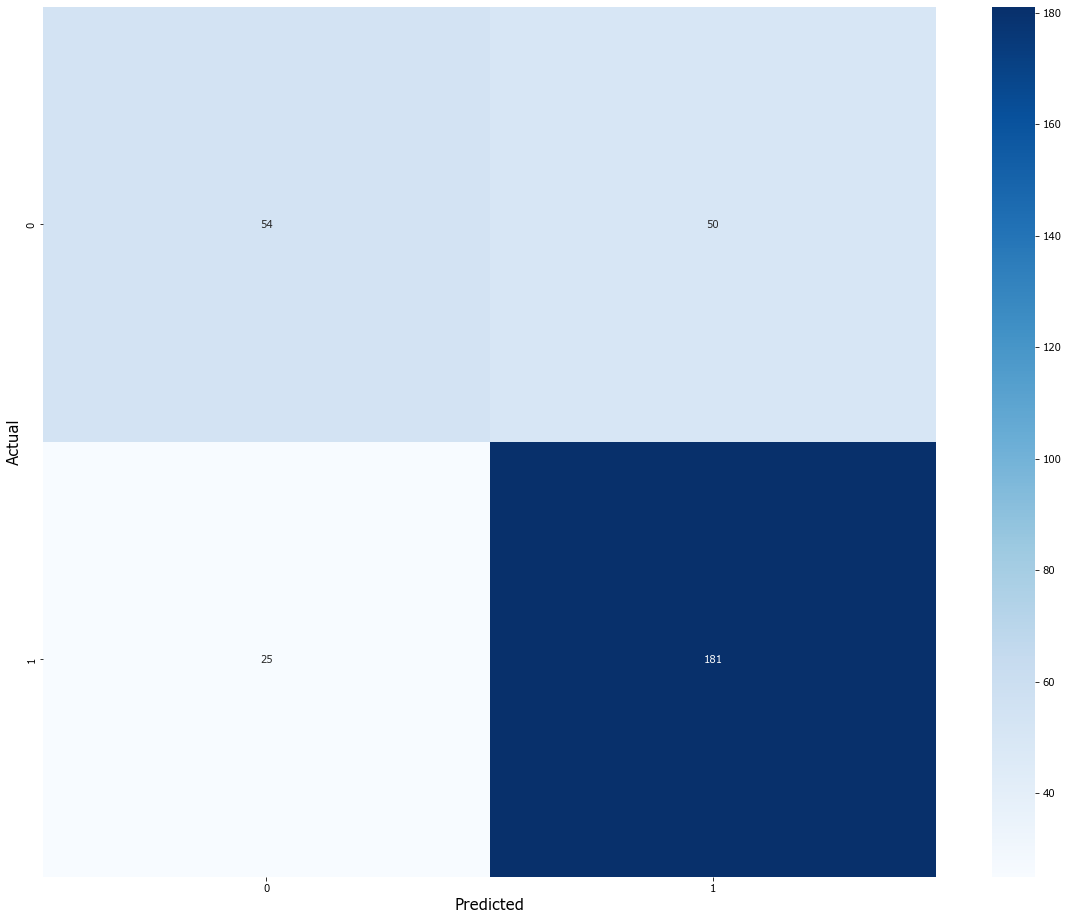

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = cnn_model.predict(X_test)
cnn_accuracy = accuracy_score(y_test,ypred.round())
print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test,ypred.round())
plt.subplots(figsize=(20,16))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cmap="Blues",cbar=True,xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
# plt.savefig('model60_e40.png')
plt.show()

In [26]:
cnn_cn

array([[ 54,  50],
       [ 25, 181]], dtype=int64)

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred.round(),target_names= classes))

              precision    recall  f1-score   support

           0       0.68      0.52      0.59       104
           1       0.78      0.88      0.83       206

    accuracy                           0.76       310
   macro avg       0.73      0.70      0.71       310
weighted avg       0.75      0.76      0.75       310



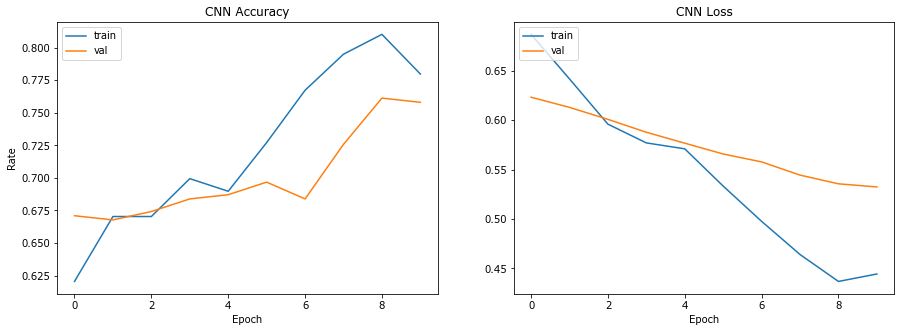

In [28]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy")
axe1[0].plot(cnn_history.history["val_accuracy"],label="accuracy")
axe1[0].legend(['train', 'val'], loc='upper left')
axe1[1].plot(cnn_history.history["loss"],label="loss")
axe1[1].plot(cnn_history.history["val_loss"],label="loss")
axe1[1].legend(['train', 'val'], loc='upper left')
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()

In [ ]:
# word cloud